### MAE와 MSE의 장점을 서로 비교해보는 예제

절대 평균 오차 : $MAE = \frac{\sum|y-y_{pred}|}{N}$

제곱 평균 오차 : $MSE = \frac{\sum|y^2-y_{pred}^2|}{N}$

* 제곱 평균 오차 => 안정적인 수렴 (학습이 다 되어가는 점에서 Gradient가 확 준다)
* 절대 평균 오차 => 이상값(outlier)에 강건


In [1]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(100)
tf.random.set_random_seed(100)

# Tensorboard의 Log파일이 저장될 위치
LOG_DIR = "./logs/"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

## 데이터 셋

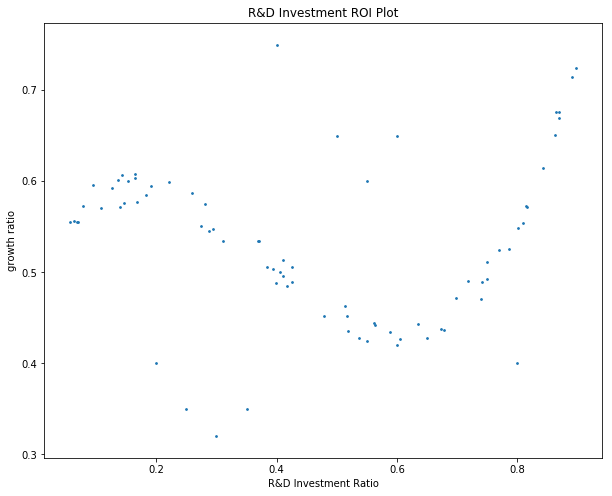

In [55]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 100) # 20% ~ 80% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.uniform(0,0.04) 
           for x in invests]) # 예상 수익률

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

## 학습 데이터 셋과 평가 데이터 셋 분리
# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

## 이상 값을 데이터 셋에 추가

# 이상값 
outlier_invests = [[0.2 ],[0.25],[0.3 ],[0.35],[0.4 ],
                   [0.5 ],[0.55],[0.6 ],[0.8 ]]
outlier_growths = [[0.4],[0.35],[0.32],[0.35],[0.75],
                   [0.65],[0.60],[0.65],[0.4]]

# 이상값을 학습 데이터 셋에 추가
train_invests = np.concatenate([train_invests,outlier_invests],axis=0)
train_growths = np.concatenate([train_growths,outlier_growths],axis=0)

plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths,s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

In [43]:
num_unit_1 = 200 # 1번째 은닉층 unit 수
num_unit_2 = 200 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, 
                               name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, 
                               name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    mse_loss = tf.losses.mean_squared_error(y, y_pred)
    mae_loss = tf.losses.absolute_difference(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(mse_loss, name='rmse')
        rmae = tf.sqrt(mae_loss, name='rmae')
    
    # training operation
    train_mse = (tf.train
                .GradientDescentOptimizer(learning_rate=0.01)
                .minimize(mse_loss))
    train_mae = (tf.train
                .GradientDescentOptimizer(learning_rate=0.0001)
                .minimize(mae_loss))
    
    variable = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0]
    gradient_mse = tf.gradients(mse_loss, variable)[0]
    gradient_mae = tf.gradients(mae_loss, variable)[0]

    0th epoch RMSE : 26.271
 5000th epoch RMSE : 0.040
10000th epoch RMSE : 0.037
15000th epoch RMSE : 0.035
20000th epoch RMSE : 0.034
25000th epoch RMSE : 0.032
30000th epoch RMSE : 0.031
35000th epoch RMSE : 0.030
40000th epoch RMSE : 0.030
45000th epoch RMSE : 0.029


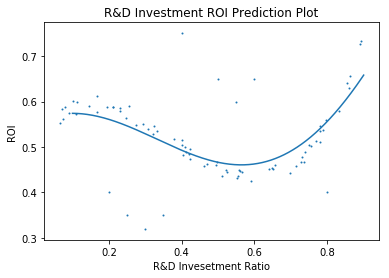

In [46]:
# 학습
n_epoch = 50000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    gradient_history = []
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_mse,feed_dict={X:train_invests,
                                      y:train_growths})
        
        if epoch % 5000 == 0:
            rmse_value = sess.run(rmse,
                      feed_dict={X: test_invests, y:test_growths})
            print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
            gradient_value = sess.run(gradient_mse,feed_dict={
                X: train_invests, y:train_growths
            })
            gradient_history.append(gradient_value)
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

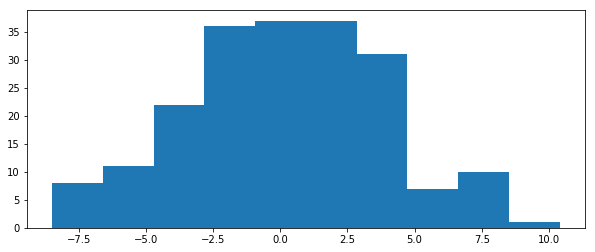

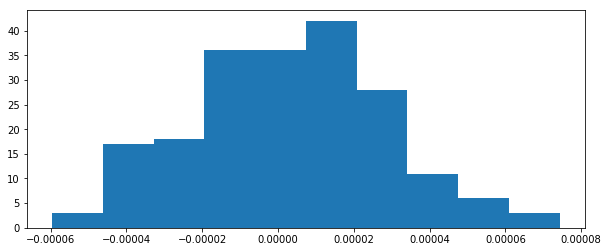

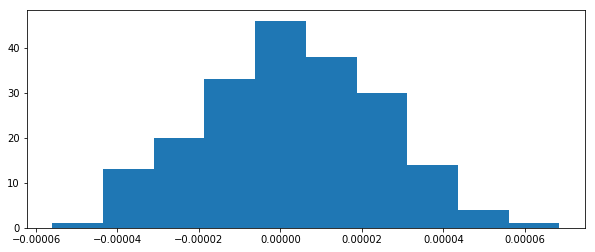

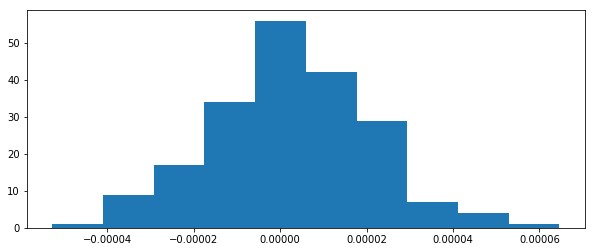

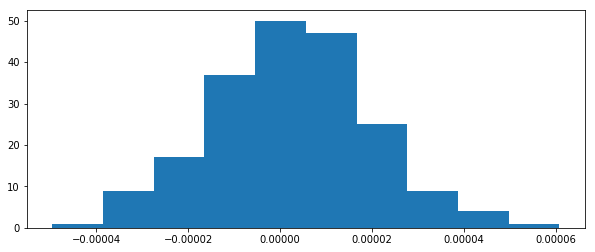

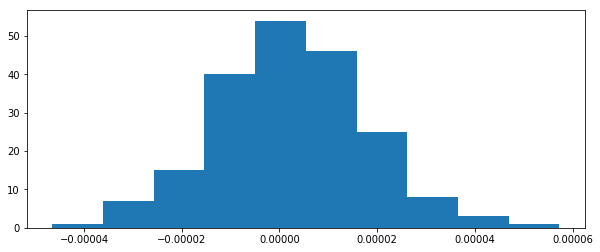

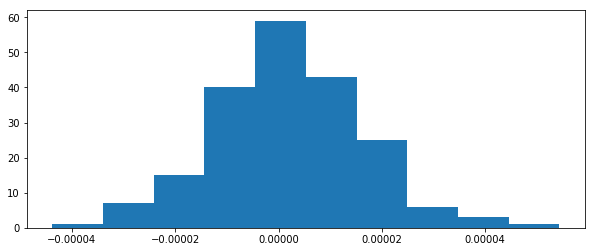

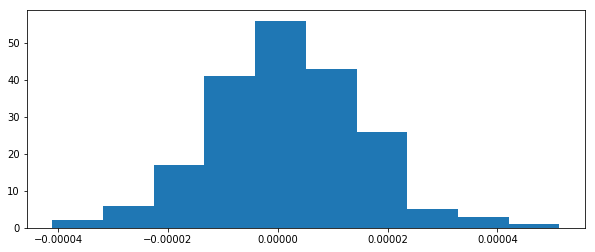

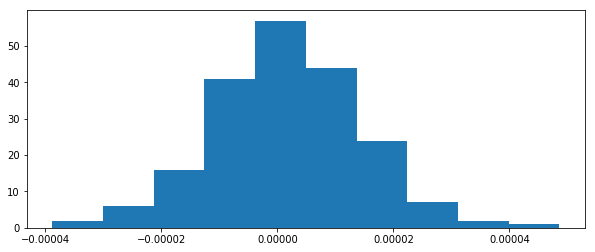

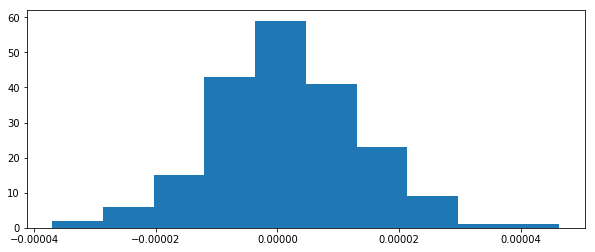

In [47]:
for gradient in gradient_history:
    plt.figure(figsize=(10,4))
    plt.hist(gradient.flatten())
    plt.show()

    0th epoch RMAE : 2.582
 5000th epoch RMAE : 0.225
10000th epoch RMAE : 0.203
15000th epoch RMAE : 0.193
20000th epoch RMAE : 0.186
25000th epoch RMAE : 0.179
30000th epoch RMAE : 0.173
35000th epoch RMAE : 0.167
40000th epoch RMAE : 0.161
45000th epoch RMAE : 0.155


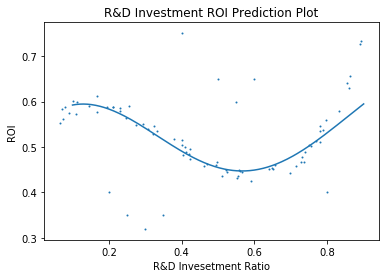

In [44]:
# 학습
n_epoch = 50000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    gradient_history = []
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_mae,feed_dict={X:train_invests,
                                      y:train_growths})
        
        if epoch % 5000 == 0:
            rmae_value = sess.run(rmae,
                      feed_dict={X: test_invests, y:test_growths})
            print("{:5d}th epoch RMAE : {:2.3f}".format(epoch, 
                                                        rmae_value))
            gradient_value = sess.run(gradient_mae,feed_dict={
                X: train_invests, y:train_growths
            })
            gradient_history.append(gradient_value)
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

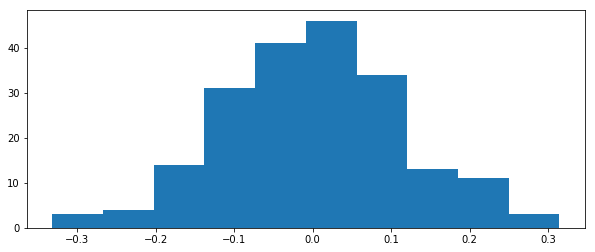

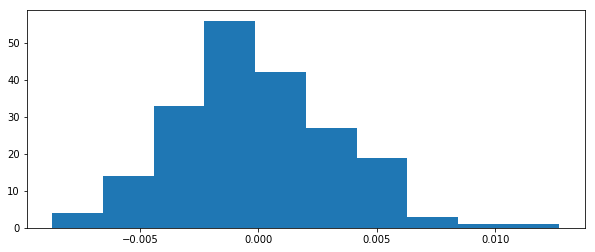

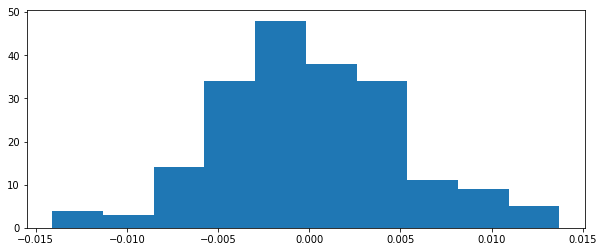

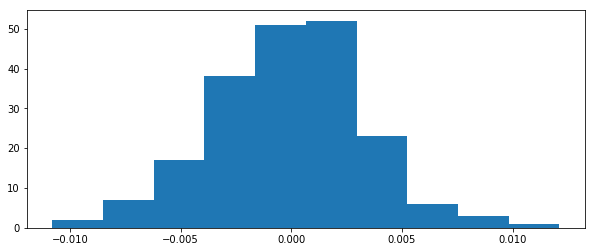

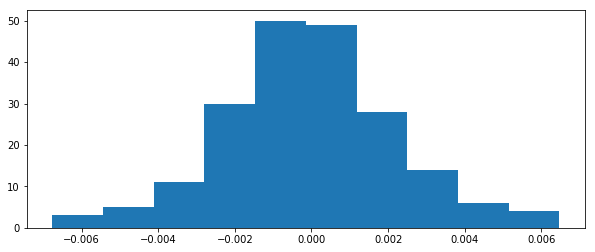

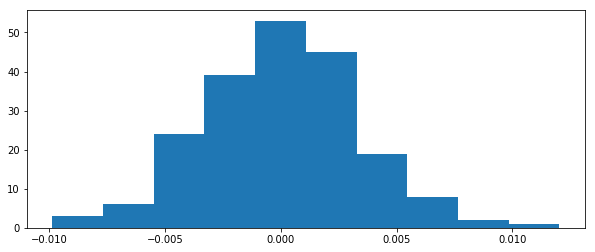

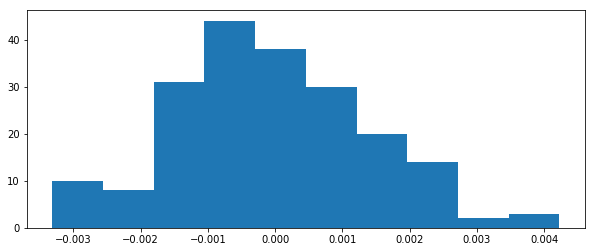

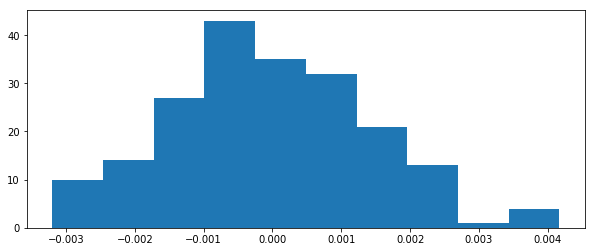

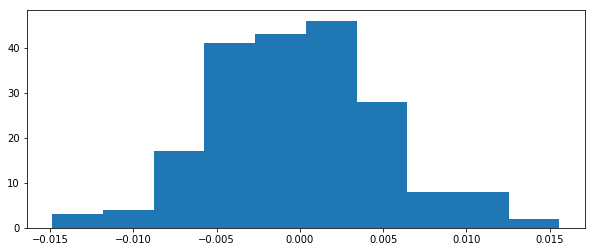

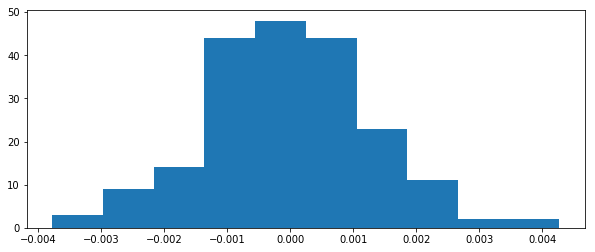

In [45]:
for gradient in gradient_history:
    plt.figure(figsize=(10,4))
    plt.hist(gradient.flatten())
    #plt.xlim((-5,5))
    plt.show()

In [60]:
0.3/0.004

75.0

In [57]:
# 강한 outlier를 몇개 추가

strong_outlier_invests = [[0.2],[0.3]]
strong_outlier_growths = [[-0.5],[-0.8]]

train_invests = np.concatenate([train_invests,strong_outlier_invests],
                               axis=0)
train_growths = np.concatenate([train_growths,strong_outlier_growths],
                               axis=0)

plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths,s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

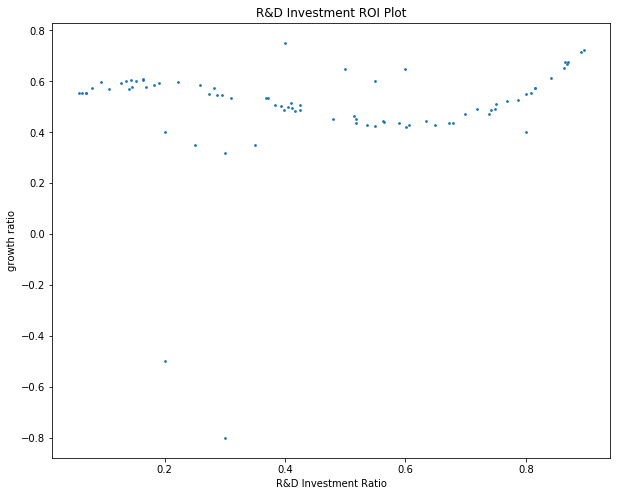

    0th epoch RMSE : 13.039
 5000th epoch RMSE : 0.071
10000th epoch RMSE : 0.071
15000th epoch RMSE : 0.070
20000th epoch RMSE : 0.070
25000th epoch RMSE : 0.069
30000th epoch RMSE : 0.069
35000th epoch RMSE : 0.069
40000th epoch RMSE : 0.069
45000th epoch RMSE : 0.069


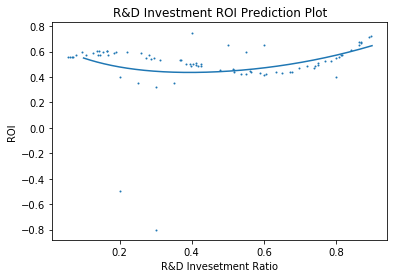

In [58]:
# 학습
n_epoch = 50000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    gradient_history = []
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_mse,feed_dict={X:train_invests,
                                      y:train_growths})
        
        if epoch % 5000 == 0:
            rmse_value = sess.run(rmse,
                      feed_dict={X: test_invests, y:test_growths})
            print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
            gradient_value = sess.run(gradient_mse,feed_dict={
                X: train_invests, y:train_growths
            })
            gradient_history.append(gradient_value)
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

    0th epoch RMAE : 1.509
 5000th epoch RMAE : 0.115
10000th epoch RMAE : 0.110
15000th epoch RMAE : 0.106
20000th epoch RMAE : 0.104
25000th epoch RMAE : 0.103
30000th epoch RMAE : 0.102
35000th epoch RMAE : 0.101
40000th epoch RMAE : 0.100
45000th epoch RMAE : 0.099


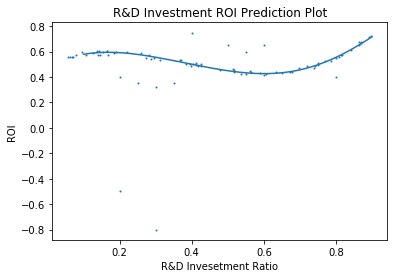

In [59]:
# 학습
n_epoch = 50000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    gradient_history = []
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_mae,feed_dict={X:train_invests,
                                      y:train_growths})
        
        if epoch % 5000 == 0:
            rmae_value = sess.run(rmae,
                      feed_dict={X: test_invests, y:test_growths})
            print("{:5d}th epoch RMAE : {:2.3f}".format(epoch, 
                                                        rmae_value))
            gradient_value = sess.run(gradient_mae,feed_dict={
                X: train_invests, y:train_growths
            })
            gradient_history.append(gradient_value)
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()